In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

In [2]:
d = pd.read_csv("sample_clean_tau.csv")

In [3]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

In [4]:
def float_keys(d, keys):
    for k in keys:
        arr = []
        for i in range(len(d)):
            val = d[k][i]
            try:
                arr.append(float(val))
            except:
                arr.append(np.nan)
        d[k] = arr
    return d

from scipy.interpolate import interp1d
dconv = pd.read_csv("data/EEM_dwarf_UBVIJHK_colors_Teff.txt", comment='#', delim_whitespace=True)
dconv = float_keys(dconv, ['Teff', 'B-V', 'V-Ks', 'Msun'])
tfromvk = interp1d(dconv['V-Ks'], dconv['Teff'])
tfrombv = interp1d(dconv['B-V'], dconv['Teff'])
bvfromt = interp1d(dconv['Teff'], dconv['B-V'])
bvfromvk = interp1d(dconv['V-Ks'], dconv['B-V'])

def mfilter(x, y, dx, N=100, mean=False, Nmin=10):
    xarr = np.linspace(x.min(), x.max(), N)
    yarr = []
    yfilt = []
    yl, yu = [], []
    for i in range(len(xarr)):
        idx = np.abs(x - xarr[i]) < dx
        if np.sum(idx) > Nmin:
            if mean:
                yfilt.append(np.mean(y[idx]))
            else:
                yfilt.append(np.median(y[idx]))
        else:
            yfilt.append(np.nan)
    return xarr, np.array(yfilt)

def rper_ro(ro, ro_th=0.84, beta1=-0.04, beta2=-2.61):
    ro = np.atleast_1d(ro)
    ret = (ro/ro_th)**beta1
    idx = ro > ro_th
    ret[idx] = (ro[idx]/ro_th)**beta2
    return ret*10798.6

def Rhk_ro_hm08(ro):
    logret = -4.522 - 0.337 * (ro - 0.814)
    idx = ro < 0.3
    logret[idx] = -4.23 - 1.451 * (ro[idx] - 0.233)
    return 10**(logret)

def Rhk_ro(ro, logC1=-4.745, beta1=-0.458, beta2=-1.222, logro0=-0.456):
    ro = np.atleast_1d(ro)
    C1, ro0 = 10**logC1, 10**logro0
    C2 = C1 * ro0**(beta1-beta2)
    ret = C1 * ro**beta1
    idx = ro > ro0
    ret[idx] = C2 * ro[idx]**beta2
    return ret

In [5]:
def tau_n84(bv):
    #bv = bvfromt(np.atleast_1d(teff))
    x = 1. - np.atleast_1d(bv)
    ret = 1.362 - 0.166 * x + 0.025 * x**2 - 5.323 * x**3
    ret[x<0] = 1.362 - 0.14 * x[x<0]
    return 10**ret

def tauconv_l21(tau):
    return -30.7 + 15.2*tau - 2.16*tau**2 + 0.192*tau**3 - 0.00839*tau**4 + 0.000141*tau**5

## X-ray data from Wright et al. (2011)

In [7]:
dx = pd.read_csv("data/wright11.tsv", comment='#', delimiter='|')
dx['teff'] = tfromvk(dx['V-K'])
dx['B-V'] = bvfromvk(dx['V-K'])
dx['tau'] = tauconv_l21(tau_n84(dx['B-V']))
dx['Ro'] = dx.Prot/dx.tau

In [8]:
dx = dx.sort_values("Ro").reset_index(drop=True)

## logR'HK

#### MH08 x Mittag+18

In [9]:
dc = pd.read_csv("data/mh08.tsv", comment='#', delimiter='|')
arr = []
for n in dc.OName:
    arr.append(n.strip(" "))
dc['OName'] = arr

In [10]:
dmit = pd.read_csv('data/mittag18.csv', encoding="shift-jis")
arr = []
for n in dmit.Object:
    arr.append(n.replace("_", " "))
dmit['Object'] = arr
dmit['Prot'] = dmit['Per (day)']

In [11]:
dc = pd.merge(dc, dmit, left_on='OName', right_on='Object')

In [12]:
dc['teff'] = tfrombv(dc['(B-V)0'])
dc['tau'] = tauconv_l21(tau_n84(dc['(B-V)0']))
dc['ro'] = dc.Prot / dc.tau

#### Lehtinen+2020

In [13]:
dc2 = pd.read_csv("data/lehtinen20.tsv", comment='#', delimiter='|')
dc2 = float_keys(dc2, ['logR\'HK', 'Prot', 'Ro'])
dc2lit = pd.read_csv("data/lehtinen20lit.tsv", comment='#', delimiter='|')
dc2lit = float_keys(dc2lit, ['Teff', 'B-V'])
dc2 = pd.merge(dc2, dc2lit, on='Name')
dc2['tau'] = tauconv_l21(tau_n84(dc2['B-V']))
dc2['ro'] = dc2.Prot / dc2.tau
idxms = dc2.Evol == 'MS'

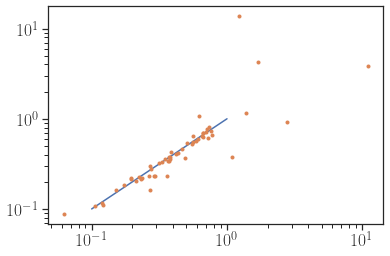

In [14]:
plt.xscale('log')
plt.yscale('log')
x0 = np.logspace(-1, 0, 100)
plt.plot(x0, x0)
plt.plot(dc2[idxms].Ro, dc2[idxms].ro, '.')

In [15]:
# Metcalfe
dc3 = pd.read_csv("data/metcalfe16.txt", delim_whitespace=True)
dg = pd.read_csv("data/DR2PapTable1.txt", delimiter='&')
dg['kepid'] = dg.KIC
dc3 = pd.merge(dc3, dg, on='kepid')
dc3['tau'] = tauconv_l21(tau_n84(dc3['B-V']))
dc3['ro'] = dc3.P_rot/dc3.tau

In [16]:
#d['bp_rp-est'] = bprpfunc(d.teff)
#d['tauc21-est'] = tau_c21(d.teff)
d['ro'] = d.Prot / tauconv_l21(tau_n84(bvfromt(d.teff)))

In [17]:
plotdir = 'systematics/'

## Comparison (data)

In [18]:
import warnings
warnings.filterwarnings('ignore')

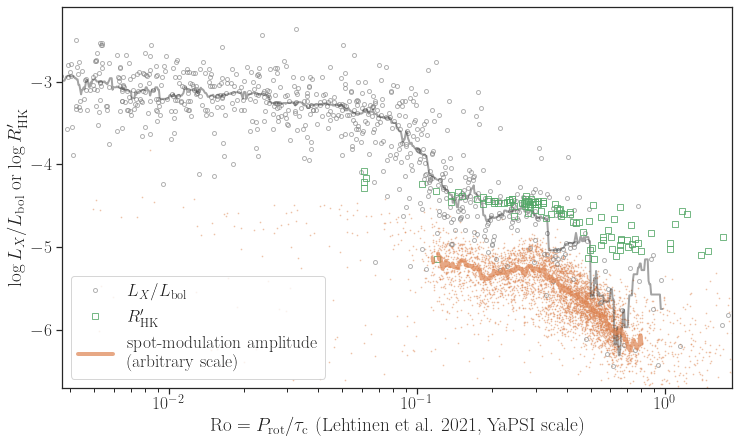

In [20]:
plt.figure(figsize=(12,7))
plt.xlim(1e-2/2.7, 5/2.7)
plt.xscale("log")
plt.ylim(-6.7, -2.1)
#plt.ylabel("activity level from different indicators\n(arbitrary logarithmic scale)")
plt.ylabel("$\log L_X/L_\mathrm{bol}$ or $\log R'_\mathrm{HK}$")
plt.xlabel(r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$ (Lehtinen et al. 2021, YaPSI scale)")

plt.plot(dx.Ro, dx['Lx/bol'], '.', mfc='none', mew=1, alpha=0.6, color='gray', markersize=8,
         label='$L_X/L_\mathrm{bol}$')
xfilt, yfilt = mfilter(np.log10(dx.Ro), dx['Lx/bol'], 0.03+0.01, N=1000, mean=False, Nmin=3)
plt.plot(10**xfilt, yfilt, '-', #label='median filter (0.06dex)', 
         color='k', lw=2, alpha=0.4)

hks = 0.
plt.plot(dc.ro, dc["logR'HK"]+hks, 's', mfc='none', mew=0.8, color='C2', label="$R'_\mathrm{HK}$")
plt.plot(dc2[idxms]['Ro'], dc2[idxms]["logR'HK"]+hks, 's', mew=0.8, mfc='none', color='C2')
plt.plot(dc3.ro, dc3.logRHK, 's', color='C2', mew=0.8, mfc='none') # overlaps?

yamp = np.log10(d.Rper/rper_ro(0.5))-4.8-0.5
plt.plot(d.ro, yamp, '.', color='C1', markersize=1.5, alpha=0.4, zorder=-1000)
#plt.plot(d.Pnorm, yamp, '.', color='C1', markersize=0.1,
#        label='spot-modulation amplitude\n(this work, amplitude scaled)')
xfilt, yfilt = mfilter(np.log10(d.ro), yamp, 0.01, N=1000, mean=False, Nmin=30)
plt.plot(10**xfilt, yfilt, '-', #label='median filter (0.06dex)', 
         color='C1', lw=4, alpha=0.7, label='spot-modulation amplitude\n(arbitrary scale)')
#plt.plot(roR, np.log10(rper_ro(roR)/rper_ro(0.5))-4.7, lw=4, alpha=0.5, color='C1',
#         label='spot-modulation amplitude\n(this work, amplitude scaled)')
plt.legend(loc='lower left')
plt.savefig(plotdir+"comparison_data_all_l21-2.png", dpi=200, bbox_inches="tight")